In [2]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, f1_score,  precision_score, recall_score, confusion_matrix, roc_curve, auc
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from peft import get_peft_model, LoraConfig, TaskType
from datasets import Dataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


d:\Python_venv\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

# Path to the pipe-delimited CSV file
file_path = 'combined_file.csv'  # Replace with your file path

# Read the pipe-delimited file into a DataFrame
df_file = pd.read_csv(file_path, sep='|')

# Display the first few rows of the DataFrame
print(df_file.head())

df = df_file.iloc[:, 1:].copy()

            ID                                     Title_Abstract   Label
0  ID:30872385  Title:Comparison of methodologies for the dete...  Cancer
1  ID:30873683  Title:Tumour biomarkers-Tracing the molecular ...  Cancer
2  ID:30874851  Title:Pomalidomide, cyclophosphamide, and dexa...  Cancer
3  ID:30875581  Title:Aggressive variants of prostate cancer -...  Cancer
4  ID:30875950  Title:Circulating Tumour Cells (CTC), Head and...  Cancer


In [4]:
df['Label_array'] = df['Label'].apply(lambda x: [x])
df["Label_array"].tail(10) 

990    [Non-Cancer]
991    [Non-Cancer]
992    [Non-Cancer]
993    [Non-Cancer]
994    [Non-Cancer]
995    [Non-Cancer]
996    [Non-Cancer]
997    [Non-Cancer]
998    [Non-Cancer]
999    [Non-Cancer]
Name: Label_array, dtype: object

In [5]:
# === 2. Encode Labels ===
mlb = MultiLabelBinarizer()
df['label_ids'] = mlb.fit_transform(df['Label_array']).astype(np.float32).tolist()

In [ ]:
#df["Label_array"].value_counts()

In [104]:
print(df.head())

                                      Title_Abstract   Label Label_array  \
0  Title:Comparison of methodologies for the dete...  Cancer    [Cancer]   
1  Title:Tumour biomarkers-Tracing the molecular ...  Cancer    [Cancer]   
2  Title:Pomalidomide, cyclophosphamide, and dexa...  Cancer    [Cancer]   
3  Title:Aggressive variants of prostate cancer -...  Cancer    [Cancer]   
4  Title:Circulating Tumour Cells (CTC), Head and...  Cancer    [Cancer]   

    label_ids  
0  [1.0, 0.0]  
1  [1.0, 0.0]  
2  [1.0, 0.0]  
3  [1.0, 0.0]  
4  [1.0, 0.0]  


In [105]:
df['label_ids'] 

0      [1.0, 0.0]
1      [1.0, 0.0]
2      [1.0, 0.0]
3      [1.0, 0.0]
4      [1.0, 0.0]
          ...    
995    [0.0, 1.0]
996    [0.0, 1.0]
997    [0.0, 1.0]
998    [0.0, 1.0]
999    [0.0, 1.0]
Name: label_ids, Length: 1000, dtype: object

In [106]:
len(mlb.classes_)

2

In [6]:
# sample(frac=1) to reshuffle the DataFrame rows
# Resets the index after shuffling.
# drop=True ensures the old index is not added as a new column.

df = df.sample(frac=1).reset_index(drop=True)

In [108]:
#df = df.iloc[:100].reset_index(drop=True)

In [7]:
df["label_ids"].value_counts()

label_ids
[1.0, 0.0]    500
[0.0, 1.0]    500
Name: count, dtype: int64

In [110]:
df["label_ids"].head(10)


0    [1.0, 0.0]
1    [0.0, 1.0]
2    [1.0, 0.0]
3    [0.0, 1.0]
4    [0.0, 1.0]
5    [0.0, 1.0]
6    [1.0, 0.0]
7    [0.0, 1.0]
8    [0.0, 1.0]
9    [1.0, 0.0]
Name: label_ids, dtype: object

In [8]:

# === 3. Train/Test Split ===
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# === 4. Tokenizer and Dataset ===
model_name = "distilbert-base-uncased"
# model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(example):
    return tokenizer(example['Title_Abstract'], truncation=True, padding=True)

train_dataset = Dataset.from_pandas(train_df[['Title_Abstract', 'label_ids']])
test_dataset = Dataset.from_pandas(test_df[['Title_Abstract', 'label_ids']])

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

Map: 100%|██████████| 200/200 [00:00<00:00, 3349.78 examples/s]


In [175]:
total_tokens = 0
for item in train_dataset:
    text = item["Title_Abstract"]  
    tokens = tokenizer(text, truncation=False, padding=False)["input_ids"]
    total_tokens += len(tokens)

print(f"Total tokens in the training dataset: {total_tokens}")

Token indices sequence length is longer than the specified maximum sequence length for this model (572 > 512). Running this sequence through the model will result in indexing errors


Total tokens in the training dataset: 279746


In [112]:
print(train_dataset[:5]) 

{'Title_Abstract': ['Title:EPIK-O/ENGOT-OV61: alpelisib plus olaparib vs cytotoxic chemotherapy in high-grade serous ovarian cancer (phase III study).Abstract:Patients with platinum-resistant or -refractory high-grade serous ovarian cancer (HGSOC) have a poor prognosis, and their management represents a substantial unmet medical need. Preclinical data and results from a phase Ib trial demonstrated the efficacy and tolerability of the combination of the α-specific phosphatidylinositol-3-kinase (PI3K) inhibitor alpelisib plus the poly(adenosine diphosphate-ribose) polymerase (PARP) inhibitor olaparib in platinum-resistant, non-<i>BRCA</i>-mutated ovarian cancer. Here, we describe the study design and rationale for the phase III, multicenter, open-label, randomized, active-controlled EPIK-O/ENGOT-OV61 trial investigating alpelisib in combination with olaparib compared with standard-of-care chemotherapy in patients with platinum-resistant or -refractory HGSOC with no germline <i>BRCA</i> m

In [ ]:

# === 5. Model + LoRA Config ===
base_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(mlb.classes_), problem_type="multi_label_classification")

peft_config = LoraConfig(
    r=8,
    lora_alpha=32,
    task_type=TaskType.SEQ_CLS,
    lora_dropout=0.1,
    bias="none",
    target_modules=["q_lin", "v_lin"]  # For DistilBERT["q_lin", "v_lin"]; use ["query", "value"] for BERT-like models
)
model = get_peft_model(base_model, peft_config)

# === 6. Training Arguments ===
args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=5,
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="no",
    load_best_model_at_end=False,
)

# === 7. Compute Metrics ===
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = torch.sigmoid(torch.tensor(logits)).numpy()
    binary_preds = (preds > 0.5).astype(int)
    accuracy = accuracy_score(labels, binary_preds)
    f1 = f1_score(labels, binary_preds, average='macro')
    #precision = precision_score(labels, binary_preds, average='macro', zero_division=0)
    #recall = recall_score(labels, binary_preds, average='macro', zero_division=0)
    return {"accuracy": accuracy, "f1": f1}

# === 8. Trainer Setup ===
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# === 9. Train the Model ===
trainer.train()



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
d:\Python_venv\.venv\lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\tarun\AppData\Local\Temp\ipykernel_1539412\1616263120.py:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatical

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.463700,0.165187,0.955000,0.954286
2,0.269400,0.118205,0.975000,0.974721
3,0.209500,0.111008,0.960000,0.959673
4,0.201800,0.117210,0.960000,0.959673
5,0.206900,0.121488,0.960000,0.959673


TrainOutput(global_step=2000, training_loss=0.2702580718994141, metrics={'train_runtime': 3440.5801, 'train_samples_per_second': 1.163, 'train_steps_per_second': 0.581, 'total_flos': 538957627392000.0, 'train_loss': 0.2702580718994141, 'epoch': 5.0})

In [ ]:
# === 10. Evaluate on Test Set ===
import torch.nn.functional as F

# Convert logits to softmax probabilities
predictions = trainer.predict(test_dataset)
logits_tensor = torch.tensor(predictions.predictions)
probs = F.softmax(logits_tensor, dim=1).numpy()
pred_labels = (probs > 0.5).astype(int)




Predicted Categories:
{'predicted_labels': ('Cancer',)}


In [ ]:
print("\nAccuracy:", accuracy_score(predictions.label_ids, pred_labels))
print("F1 Score:", f1_score(predictions.label_ids, pred_labels, average="macro"))
print("Confusion Matrix:\n", confusion_matrix(predictions.label_ids.argmax(axis=1), pred_labels.argmax(axis=1)))


Confidence Scores for Each Category:
{'Cancer': 1.0, 'Non-Cancer': 3.5678624e-08}

Accuracy: 0.96
F1 Score: 0.959673354168767
Confusion Matrix:
 [[ 87   3]
 [  5 105]]


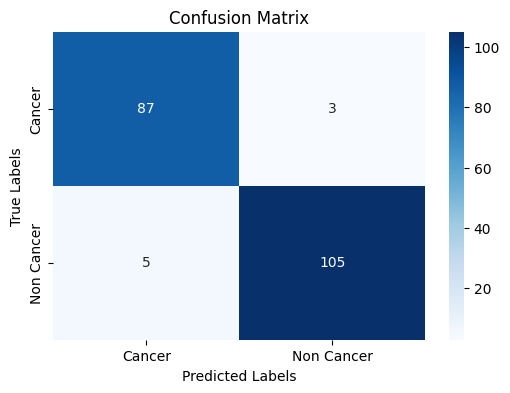

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(predictions.label_ids.argmax(axis=1), pred_labels.argmax(axis=1))
# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cancer', 'Non Cancer'], yticklabels=['Cancer', 'Non Cancer'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


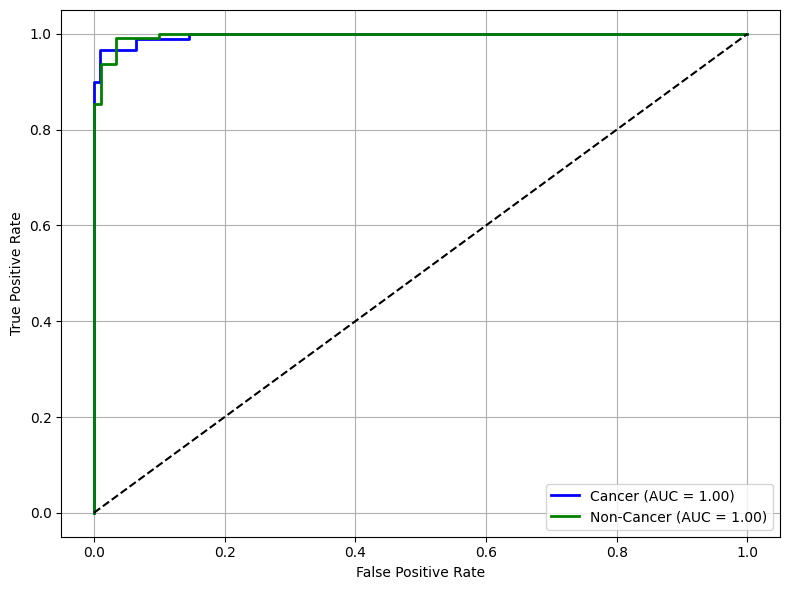

In [ ]:

# === 12. AUC-ROC Curve ===
true_labels = np.array(predictions.label_ids)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(mlb.classes_)):
    fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(mlb.classes_))]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(mlb.classes_)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= len(mlb.classes_)
roc_auc["macro"] = auc(all_fpr, mean_tpr)

# Plot
plt.figure(figsize=(8, 6))
colors = ['blue', 'green']
for i, color in zip(range(len(mlb.classes_)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"{mlb.classes_[i]} (AUC = {roc_auc[i]:.2f})")

# plt.plot(all_fpr, mean_tpr, color='darkorange', linestyle='--',
#          label=f"Macro-average (AUC = {roc_auc['macro']:.2f})", lw=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# plt.title("Multi-label AUC-ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()


In [119]:
from peft import PeftModel, PeftConfig

# Merge adapter weights
model = model.merge_and_unload()

# Save merged model
model.save_pretrained("saved_model/merged_model")
tokenizer.save_pretrained("saved_model/merged_model")

('saved_model/merged_model\\tokenizer_config.json',
 'saved_model/merged_model\\special_tokens_map.json',
 'saved_model/merged_model\\vocab.txt',
 'saved_model/merged_model\\added_tokens.json',
 'saved_model/merged_model\\tokenizer.json')

In [124]:
df.head(10)

,Title_Abstract,Label,Label_array,label_ids
0,Title:Pathological and Molecular Features of G...,Cancer,[Cancer],"[1.0, 0.0]"
1,Title:Large-Scale Exome-wide Association Analy...,Non-Cancer,[Non-Cancer],"[0.0, 1.0]"
2,Title:[Pituitary adenomas].Abstract:Despite ch...,Cancer,[Cancer],"[1.0, 0.0]"
3,Title:MPD-RC 101 prospective study of reduced-...,Non-Cancer,[Non-Cancer],"[0.0, 1.0]"
4,Title:Oligodendrocyte Nf1 Controls Aberrant No...,Non-Cancer,[Non-Cancer],"[0.0, 1.0]"
5,Title:Mechanistic and evolutionary insights in...,Non-Cancer,[Non-Cancer],"[0.0, 1.0]"
6,Title:The differential diagnosis of classical ...,Cancer,[Cancer],"[1.0, 0.0]"
7,Title:Telomere-associated aging disorders.Abst...,Non-Cancer,[Non-Cancer],"[0.0, 1.0]"
8,Title:Characterization of the Phenotype Associ...,Non-Cancer,[Non-Cancer],"[0.0, 1.0]"
9,Title:Sarcomatoid carcinoma after radiotherapy...,Cancer,[Cancer],"[1.0, 0.0]"


In [126]:
# 9. Sample Prediction Output
sample_text = df["Title_Abstract"][5]
inputs = tokenizer(sample_text, return_tensors="pt")
with torch.no_grad():
    logits = model(**inputs).logits
    prob = F.softmax(logits, dim=1).squeeze().tolist()

label_map = ["Cancer","Non-Cancer"]
predicted_index = np.argmax(prob)
result = {
    "predicted_labels": [label_map[predicted_index]],
    "confidence_scores": {
        "Cancer": round(prob[0], 2),
        "Non-Cancer": round(prob[1], 2)
    }
}

print(result)

{'predicted_labels': ['Non-Cancer'], 'confidence_scores': {'Cancer': 0.0, 'Non-Cancer': 1.0}}


In [12]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from peft import LoraConfig, TaskType
from transformers import BertForSequenceClassification
from peft import get_peft_model
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix


In [13]:
test_dataset_base = Dataset.from_pandas(test_df[['Title_Abstract', 'label_ids']])

In [14]:
test_dataset_base

Dataset({
    features: ['Title_Abstract', 'label_ids', '__index_level_0__'],
    num_rows: 200
})

In [15]:
# data = [
#     {
#         "title": "Title: An integrative pan-cancer analysis illustrating the key role of LRP11 in cervical cancer.",
#         "abstract": "Abstract: Low density lipoprotein receptor-related protein 11 (LRP11) was involved in the progression of several tumors. However, its role in cervical cancer still remains uncertain.",
#         "label": [1, 0]  # Cancer, Non-Cancer
#     },
#     {
#         "title": "Title: DMAP1 is an essential regulator of ATM activity and function.",
#         "abstract": "Abstract: The hereditary autosomal recessive disease ataxia telangiectasia (A-T) is caused by mutation in the DNA damage kinase ATM. ATM's main function is to orchestrate DNA repair, thereby maintaining genomic stability.",
#         "label": [0, 1]  # Cancer, Non-Cancer
#     }
# ]

#Base Model Results

model_name = "distilbert-base-uncased"
base_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(mlb.classes_))

tokenizer = AutoTokenizer.from_pretrained(model_name)

# Create classifier pipeline
classifier = pipeline("text-classification", model=base_model, tokenizer=tokenizer, return_all_scores=True)

# Process and evaluate
y_true = []
y_pred = []



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu
d:\Python_venv\.venv\lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [16]:
for item in test_dataset_base:
    #text = item["title"] + " " + item["abstract"]
    text = item["Title_Abstract"]
    outputs = classifier(text, truncation=True)[0]

    # Extract confidence and predicted labels
    confidence_scores = {output["label"]: output["score"] for output in outputs}
    predicted_labels = [1 if confidence_scores.get(f"LABEL_{i}", 0) > 0.5 else 0 for i in range(2)]

    #y_true.append(item["label_ids"])
    y_true.append(item["label_ids"])
    y_pred.append(predicted_labels)

    # # Output
    # print("Predicted Categories:")
    # print({"predicted_labels": ["Cancer" if predicted_labels[0] else "Non-Cancer"]})
    # print("\nConfidence Scores for Each Category:")
    # print({
    #     "Cancer": confidence_scores.get("LABEL_0", 0),
    #     "Non-Cancer": confidence_scores.get("LABEL_1", 0)
    # })
    # print("-" * 40)

# Convert multi-hot vectors to flat for evaluation
y_true_flat = [label.index(1) for label in y_true]
y_pred_flat = [label.index(1) for label in y_pred]

# Metrics
accuracy = accuracy_score(y_true_flat, y_pred_flat)
f1 = f1_score(y_true_flat, y_pred_flat, average='weighted')
cm = confusion_matrix(y_true_flat, y_pred_flat)

print(f"\nAccuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print("Confusion Matrix:")
print(cm)



Accuracy: 0.55
F1 Score: 0.39
Confusion Matrix:
[[110   0]
 [ 90   0]]
